In [3]:
import sys
import os
from pathlib import Path

scripts_dir = Path().resolve()
parent_dir = scripts_dir.parent
sys.path.insert(0, str(parent_dir))

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

In [4]:
import SSM
from SSM.ssm.plots import gradient_cmap, white_to_color_cmap

In [11]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import numpy as np
import pandas as pd
import seaborn as sns

import scipy
import pyarrow

import torch

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pymc3 as pm

import Functions.inference as inference
import Functions.kinematics as kinematics
import Functions.learning as learning

In [6]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [7]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]

In [2]:
#import numpy as np
title = 'ShortSession11'
print(title)
P = np.load('../Data/MouseKinematicParameters/' + title + 'Parameters.npz', allow_pickle=True)
sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = P['sigma_a'].item(), P['sigma_x'].item(), P['sigma_y'].item(), P['sqrt_diag_V0_value'].item(), P['B'], P['Qe'], P['m0'], P['V0'], P['Z'], P['R']
print('sigma_a: ', sigma_a)
print('sqrt_diag_V0: ', sqrt_diag_V0_value)
print(" ")

ShortSession11
sigma_a:  23.888961791992188
sqrt_diag_V0:  1.1224479249567174e-05
 


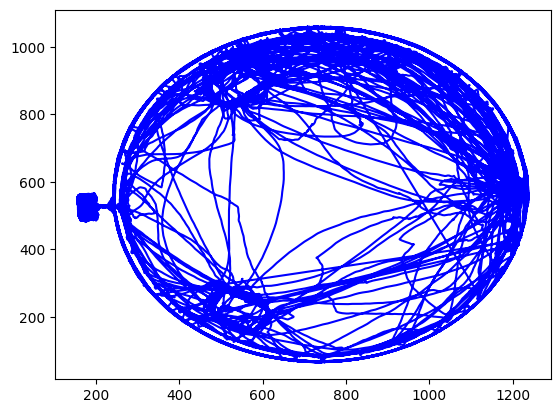

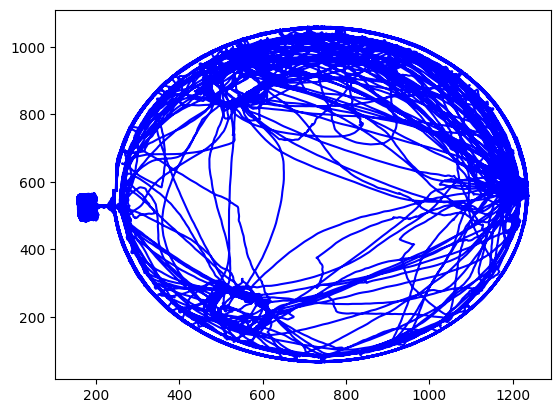

In [10]:
for session, count in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    if count != 0: continue
    title = 'ShortSession'+str(count)
    
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    plt.plot(mouse_pos.x, mouse_pos.y, color = 'blue')
    plt.show()
            
    mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)
            
    # Add smoothed kinematics data to mouse_pos
    kinematics.AddKinematics(title, mouse_pos)
            
    #mouse_pos = mouse_pos.dropna(subset=['x'])
            
    # Draw plots
    '''fig, axs = plt.subplots(4,1, figsize = (40,24))
    mouse_pos.x.plot(ax = axs[0])
    mouse_pos.y.plot(ax = axs[0])
    mouse_pos.smoothed_position_x.plot(ax = axs[1])
    mouse_pos.smoothed_position_y.plot(ax = axs[1])
    mouse_pos.smoothed_speed.plot(ax = axs[2])
    mouse_pos.smoothed_acceleration.plot(ax = axs[3])
            
    axs[0].set_ylabel('Raw Pos.')
    axs[1].set_ylabel("Smoothed Pos.")
    axs[2].set_ylabel("Smoothed Vel.")
    axs[3].set_ylabel("Smoothed Acc.")

    plt.show()'''
    plt.plot(mouse_pos.x, mouse_pos.y, color = 'blue')
    plt.show()

In [ ]:
sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = kinematics.LDSParameters_Manual(dt=0.02)


for session, count in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    if count != 0: continue
    title = 'ShortSession'+str(count)
    
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)
    obs = np.transpose(mouse_pos[["x", "y"]].to_numpy())

    # Use the first 60 seconds position data to learn the LDS parameters
    sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, m0, V0, Z, R = kinematics.LDSParameters_Learned(obs[:,:6000], sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, Z)
    #np.savez('../Data/MouseKinematicParameters/' + title + 'Parameters.npz', sigma_a = sigma_a, sigma_x = sigma_x, sigma_y = sigma_y, sqrt_diag_V0_value = sqrt_diag_V0_value, B = B, Qe = Qe, m0 = m0, V0 = V0, Z = Z, R = R)
    #np.savez('../Data/MouseKinematicParameters/RecentParameters.npz', sigma_a = sigma_a, sigma_x = sigma_x, sigma_y = sigma_y, sqrt_diag_V0_value = sqrt_diag_V0_value, B = B, Qe = Qe, m0 = m0, V0 = V0, Z = Z, R = R)
        
    Q = sigma_a**2*Qe

    # Filtering
    filterRes = inference.filterLDS_SS_withMissingValues_np(
        y=obs, B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)
    #np.savez_compressed('../Data/ProcessedMouseKinematics/' + title + 'filterRes.npz', **filterRes)
        
    # Smoothing
    smoothRes = inference.smoothLDS_SS( 
        B=B, xnn=filterRes["xnn"], Vnn=filterRes["Vnn"],
        xnn1=filterRes["xnn1"], Vnn1=filterRes["Vnn1"], m0=m0, V0=V0)
    #np.savez_compressed('../Data/ProcessedMouseKinematics/' + title + 'smoothRes.npz', **smoothRes)

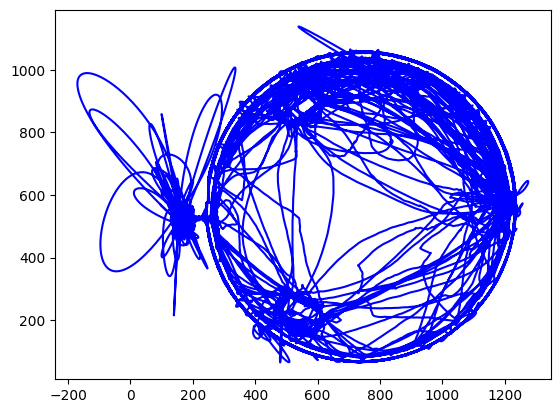

In [9]:
x_, y_ = smoothRes['xnN'][0][0], smoothRes['xnN'][3][0]
plt.plot(x_, y_, color = 'blue')
plt.show()

In [29]:
y = obs[:,:10]
dt = 0.02
pos_x0, pos_y0 = y[0,0], y[1,0]
vel_x0, vel_y0 = (y[0,1] - y[0,0])/dt, (y[1,1] - y[1,0])/dt
acc_x0, acc_y0 = (y[0,2] - y[0,0])/(dt**2), (y[1,2] - y[1,0])/(dt**2)

In [33]:
acc_y0

-10969.047546386719